<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Import-Necessary-Packages" data-toc-modified-id="Import-Necessary-Packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Necessary Packages</a></span></li><li><span><a href="#Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery" data-toc-modified-id="Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Collect Data Set From the MAST Archive Using Astroquery</a></span></li></ul></li><li><span><a href="#Spectrum-Preprocessing" data-toc-modified-id="Spectrum-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Spectrum Preprocessing</a></span></li><li><span><a href="#Creating-Source-Spectrum" data-toc-modified-id="Creating-Source-Spectrum-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating Source Spectrum</a></span></li><li><span><a href="#Creating-a-Bandpass" data-toc-modified-id="Creating-a-Bandpass-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Creating a Bandpass</a></span></li><li><span><a href="#Creating-an-Observation" data-toc-modified-id="Creating-an-Observation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Creating an Observation</a></span></li></ul></div>

# Synthetic Photometry with STIS Spectra

## Introduction

The goal of synthetic photometry is to simulate observed photometric data with spectra and the instrumental response function of the photometric filters. In the notebook, we present the process of creating synthetic photometry using STIS spectra, and the [`synphot`](https://synphot.readthedocs.io/en/latest/) and [`stsynphot`](https://stsynphot.readthedocs.io/en/latest/index.html) Python packages. We also reproduced ACS observation of star `WD1657+343` using STIS spectra, and compared the data with photometry from real ACS observations.

[`synphot`](https://synphot.readthedocs.io/en/latest/) is a Python package for simulating photometric data. It is the successor of the [`Astrolib PySynphot`](https://pysynphot.readthedocs.io/en/latest/) Python package. [`synphot`](https://synphot.readthedocs.io/en/latest/) has the funcionalities to create spectra, bandpasses, and observations, manipulating spectra and data, and computing photometric properties.

[`stsynphot`](https://stsynphot.readthedocs.io/en/latest/index.html) is an extension of [`synphot`](https://synphot.readthedocs.io/en/latest/) that implements synthetic photometry package specific to HST. It includes HST instrument-specific data and functionalities, and is used in complement with [`synphot`](https://synphot.readthedocs.io/en/latest/).

### Import Necessary Packages
- `synphot` `stsynphot` for computing synthetic photometry and simulating observations
- `astropy.io fits` `astropy.table` for accessing FITS files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `os`,`pathlib` for managing system paths
- `numpy` to handle array functions
- `stistools` for calibrating STIS data
- `matplotlib` for plotting data

In [1]:
# Import for: computing synthetic photometry and simulating observations
from astropy import units as u
from synphot import units, SourceSpectrum,Observation
from synphot.models import BlackBodyNorm1D, GaussianFlux1D
from synphot.specio import write_fits_spec
import stsynphot as stsyn  

# Import for: Reading in fits file
from astropy.table import Table
from astropy.io import fits

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
from pathlib import Path
import os

# Import for: Plotting and specifying plotting parameters
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from IPython.display import display

# Import for: Quick Calculation and Data Analysis
import numpy as np

# Import for: operations on STIS Data
import stistools

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/nmpfit.py:10: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/gfit.py:20: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


### Collect Data Set From the MAST Archive Using Astroquery
In this notebook, we use the spectrum of the star WD1657+343 as an example. We first collect the dataset OEHK05020 from the MAST archive. The spectrum was observed using the G750L grating and an exposure time of 1560 seconds

In [2]:
# change this field in you have a specific dataset to be explored
obs_id="OEHK05020"
# Search target objscy by obs_id
target = Observations.query_criteria(obs_id=obs_id)
# get a list of files assiciated with that target
FUV_list = Observations.get_product_list(target)
# Download fits files
result = Observations.download_products(FUV_list,extension='_sx1.fits')
sx1 = os.path.join("./mastDownload/HST","{}".format(obs_id),"{}_sx1.fits".format(obs_id))

INFO: Found cached file ./mastDownload/HST/oehk05020/oehk05020_crj.fits with expected size 10537920. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/oehk05020/oehk05gej_epc.fits with expected size 11520. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/oehk05020/oehk05gfj_epc.fits with expected size 11520. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/oehk05020/oehk05ggj_epc.fits with expected size 11520. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/oehk05020/oehk05gij_epc.fits with expected size 11520. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/oehk05020/oehk05020_jif.fits with expected size 86400. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/oehk05020/oehk05020_jit.fits with expected size 89280. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/oehk05020/oehk05020_jwf.fits with expected size 17280. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/oehk05020/oehk0502

## Spectrum Preprocessing
Since the synthetic photometry is computed based on the flux in the observed spectrum, the calculated value is sensitive to the data quality of the spectrum. We first need to preprocess the spectrum to ensure that the data quality meets our need to generate synthetic photometry.

We first open up the _sx1 fits file and get the wavelength, flux, and data quality of the spectrum:

In [3]:
with fits.open(sx1) as hdu:
    data = hdu[1].data
wl, flux, dq = data['WAVELENGTH'][0],data['FLUX'][0],data['DQ'][0]

Plot the spectrum without any processing:

Text(0, 0.5, 'Flux (ergs/s/cm$^2$/Å)')

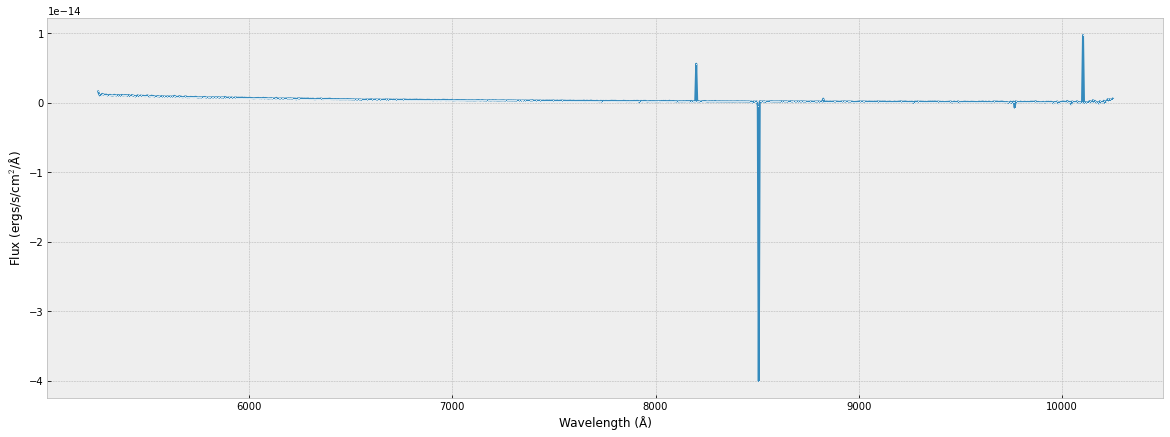

In [4]:
matplotlib.rcParams['figure.figsize'] = [20, 7]
plt.style.use('bmh')

plt.plot(wl, flux,  
             marker='.', markersize=2, markerfacecolor='w', markeredgewidth=0)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (ergs/s/cm$^2$/Å)')

As shown in the plot above, there are three "spikes" in the spectrum that are likely to be caused by bad data qualities. Since the synthetic photometry is computed numerically over the spectrum, the spikes are likely to confuse the algorithm. Thus we hope to remove the data points marked with serious data quality flags (SDQFLAGS).

The SDQFLAGS field is stored in the first extension of the fits file. It is a 16-bits binary encoded integer that markes the data quality flags considered serious. To remove the data points with serious data quality flags, we first get the value of SDQFLAGS from the header, and then create a mask using SDQFLAGS and the dq array. The mask is applied to both the wavelength and the flux arrays:

Text(0, 0.5, 'Flux (ergs/s/cm$^2$/Å)')

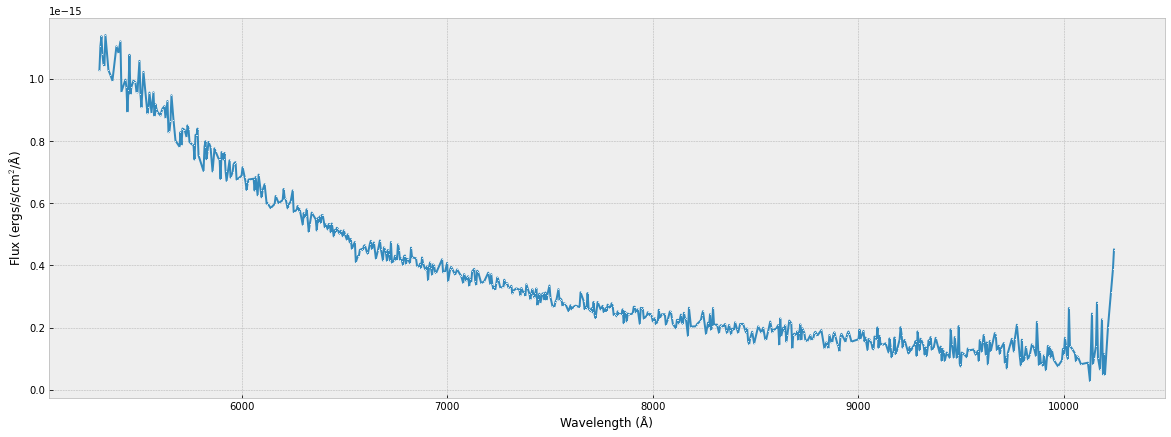

In [5]:
# get SDQFLAGS from the header of the first extension
sdqFlags = fits.getval(sx1, ext=1, keyword="SDQFLAGS")
# use the bitwise and operation between SDQFLAGS and the dq array
# so that only data points without serious data quality flags are preserved
g = (dq & sdqFlags) == 0

# apply the mask to both the wavelength and flux arrays
wl_masked = wl[g]
flux_masked = flux[g]

plt.plot(wl_masked, flux_masked,  
             marker='.', markersize=2, markerfacecolor='w', markeredgewidth=0) 
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (ergs/s/cm$^2$/Å)')

## Creating Source Spectrum
A source spectrum is used to represent astronomical sources. To generate source spectrum object in the synphot package, we can either use predefined spectrum or model, or load supported spectrum from FITS file or ASCII file. In this notebook, we will only demonstrate the procedures to read source spectrum from FITS file.

The first step is to prepare the FITS file of the spectrum in the supported format. We use the [`write_fits_spec`](https://synphot.readthedocs.io/en/latest/api/synphot.specio.write_fits_spec.html) function to write the preprocessed wavelength to a fits file:

**Notice: it is essential to confirm that the spectrum is written into the file in the correct units. Since we are using STIS spectrum, we assume that the energy is in FLAM =ergs/s/cm$^2$/Å. If spectrum from other sources is used, please enture that the unit is specified correctly.**

In [6]:
# delete the target file if it already exists
if os.path.exists("{}_source_spectrum.fits".format(obs_id.lower())):
    os.remove("{}_source_spectrum.fits".format(obs_id.lower()))
# write the preprocessed spectrum to the target fits file
write_fits_spec("{}_source_spectrum.fits".format(obs_id.lower()),wavelengths=wl_masked, fluxes=flux_masked,wave_unit=u.Angstrom,flux_unit=units.FLAM)

Now we can create an SourceSpectrum object from the FITS file we just created using the [`from_file`](https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SourceSpectrum.html#synphot.spectrum.SourceSpectrum.from_file) function in [`SourceSpectrum`](https://synphot.readthedocs.io/en/latest/synphot/spectrum.html):

In [7]:
sp = SourceSpectrum.from_file("{}_source_spectrum.fits".format(obs_id.lower()))

The SourceSpectrum object has a built-in [`plot`](https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SourceSpectrum.html#synphot.spectrum.SourceSpectrum.plot) function which wraps matplotlib functions to plot the spectrum.

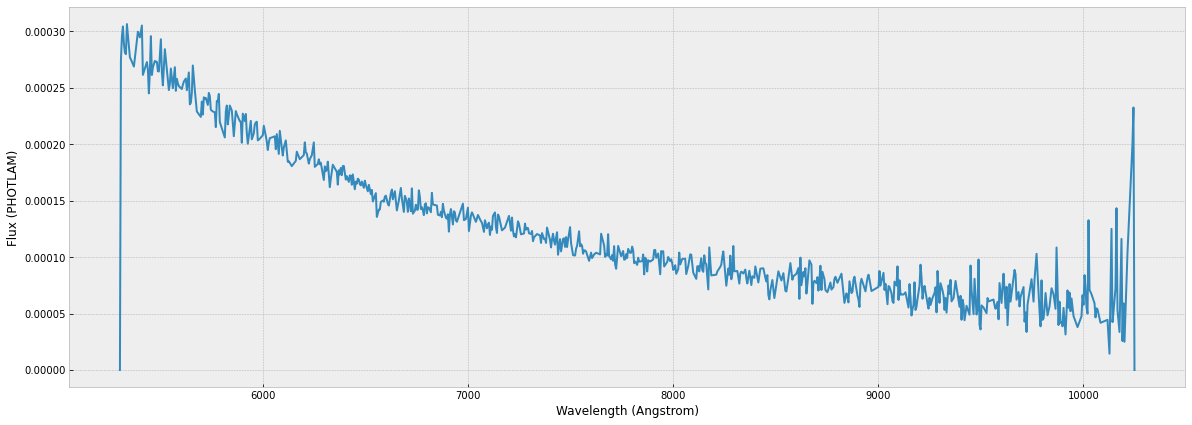

In [8]:
sp.plot()

## Creating a Bandpass
The `synphot` package has the functionality to create a bandpass with various methods including reading from file, using pre-defined filter, etc. For STScI mission, it is required to access HST filters through `stsynphot`, which contains STScI mission-specific information. In this notebook, we will use `stsynphot` to create bandpasses of the ACS filters, and apply those bandpasses to generate synthetic photometry with STIS spectrum. For more information on ACS photometry, see: [`ACS Data Analysis`](https://hst-docs.stsci.edu/acsdhb/chapter-5-acs-data-analysis).

The bandpass object is constructed through the [`band`](https://stsynphot.readthedocs.io/en/latest/api/stsynphot.spectrum.band.html#stsynphot.spectrum.band) function. The `band` function takes in an observation mode string that specifies the instrument, detector, and the filter. For instance, to create a bandpass for HST/ACS camera using WFC1 detector and F775W filter, use:

In [20]:
bp = stsyn.band('acs, wfc1, F775W')

The `band` function automatically parses the input string and created the bandpass object using the corresponding throughput files in the reference file directory.

Similar to SourceSpectrum, the Bandpass can also be plotted using the built-in `plot` function to show the sensitivity curve as a function of wavelength:

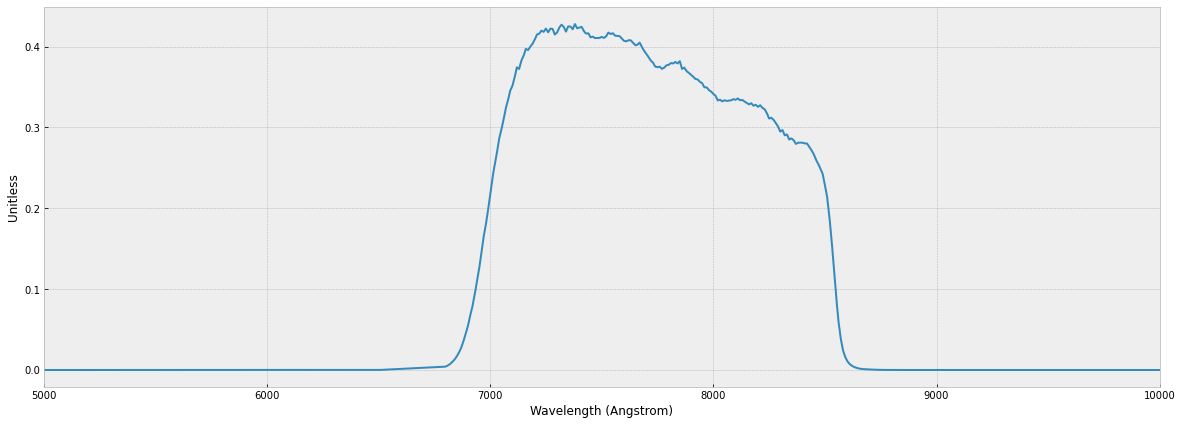

In [11]:
# zoom in to the 5000 - 10000 Angstrom wavelength range
bp.plot(left=5000,right=10000)

## Creating an Observation
An [`Observation`](https://synphot.readthedocs.io/en/latest/synphot/observation.html) is a special type of SourceSpectrum, where the source is convolved with a Bandpass.

With the SourceSpectrum and Bandpass available, we can now create an observation that simulates real photometric observation of the bandpass. The Observation object can be simply constructed by passing the SourceSpectrum and Bandpass to the Observation constructor:

In [22]:
# create an observation using sp and bp
obs = Observation(sp, bp)

<Quantity 2709.89905333 ct / s>

In [23]:
obs.effstim(u.STmag)

<Magnitude 17.80899413 mag(ST)>

In [27]:
obs.effstim(u.ABmag)

<Magnitude 17.07043378 mag(AB)>

In [24]:
obs.effstim(flux_unit='flam')

<Quantity 2.73150719e-16 FLAM>

In [26]:
area = 45238.93416
obs.countrate(area)

<Quantity 2709.89905333 ct / s>

In [28]:
obs(wl)

<Quantity [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           7.74577862e-11, 8.63904845e-11, 3.47345899e-14] PHOTLAM>

In [15]:
dir(obs)

['__add__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_band',
 '_bin_edges',
 '_binflux',
 '_binset',
 '_do_plot',
 '_force',
 '_get_arrays',
 '_get_binned_arrays',
 '_get_meta',
 '_init_bins',
 '_internal_flux_unit',
 '_internal_wave_unit',
 '_merge_meta',
 '_model',
 '_model_fconv_wav',
 '_model_param_dict',
 '_process_flux_param',
 '_process_generic_param',
 '_process_wave_param',
 '_spec',
 '_validate_binned_wavelengths',
 '_validate_flux_unit',
 '_validate_other_mul_div',
 '_validate_wavelengths',
 'as_spectrum',
 'avgwave',
 'bandpass',
 'barlam',
 'bin_edges',
 'binflux',
 'binn